In [150]:
# importing essential libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px  # for interactive visualizations
import pingouin as pgn  # hypothesis testing
import missingno as msno  # visualizing the missing values
from lifelines import KaplanMeierFitter  # plotting survival curves
from lifelines.statistics import logrank_test  # the check the discrepancy of different survival curves
from catboost import CatBoostClassifier, Pool  # for imputing missing values
from sklearn.model_selection import train_test_split  # splitting original dataset into traning and testing datasets
import statsmodels.api as sm_api  # related to statistical methods
from statsmodels import stats  # related to statistical methods
from scipy import stats as st  # related to statistical methods
from statsmodels.stats import power as pwr  # power analysis
from statsmodels.stats.proportion import proportions_ztest  # used for proportions hypothesis test

In [151]:
import warnings
warnings.filterwarnings("ignore")  # turn-off all warnings

In [152]:
# read the dataset path
dataset_path = "BRCA.csv"
cancer_df = pd.read_csv(dataset_path, parse_dates=["Date_of_Surgery", "Date_of_Last_Visit"], infer_datetime_format=True)
cancer_df.head()

,Patient_ID,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,TCGA-D8-A1XD,36,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,2017-01-15,2017-06-19,Alive
1,TCGA-EW-A1OX,43,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,2017-04-26,2018-11-09,Dead
2,TCGA-A8-A079,69,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,2017-09-08,2018-06-09,Alive
3,TCGA-D8-A1XR,56,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,2017-01-25,2017-07-12,Alive
4,TCGA-BH-A0BF,56,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,2017-05-06,2019-06-27,Dead


In [153]:
cancer_df.shape

(334, 16)

In [154]:
# check cancer_df for dtypes and missing values
cancer_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Patient_ID          334 non-null    object        
 1   Age                 334 non-null    int64         
 2   Gender              334 non-null    object        
 3   Protein1            334 non-null    float64       
 4   Protein2            334 non-null    float64       
 5   Protein3            334 non-null    float64       
 6   Protein4            334 non-null    float64       
 7   Tumour_Stage        334 non-null    object        
 8   Histology           334 non-null    object        
 9   ER status           334 non-null    object        
 10  PR status           334 non-null    object        
 11  HER2 status         334 non-null    object        
 12  Surgery_type        334 non-null    object        
 13  Date_of_Surgery     334 non-null    datetime64[ns]

In [155]:
df = cancer_df.copy()
df.dropna().nunique()

Patient_ID            317
Age                    57
Gender                  2
Protein1              316
Protein2              317
Protein3              317
Protein4              316
Tumour_Stage            3
Histology               3
ER status               1
PR status               1
HER2 status             2
Surgery_type            4
Date_of_Surgery       178
Date_of_Last_Visit    285
Patient_Status          2
dtype: int64

In [156]:
# normalized patient_status
df.Patient_Status.value_counts(normalize=True).to_frame().T

,Alive,Dead
Patient_Status,0.794393,0.205607


[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'Class')]

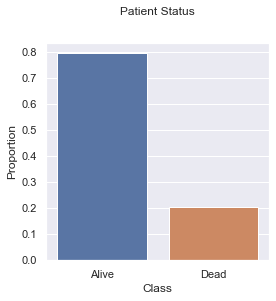

In [157]:
# visualize the proportions for the patient_status
sns.set()
plt.figure(figsize=(4, 4))
sns.set_context("notebook")
fig = sns.barplot(data=df.Patient_Status.value_counts(normalize=True).to_frame().T)
fig.set_title("Patient Status", y=1.1)
fig.set(ylabel="Proportion",
        xlabel="Class")

In [158]:
# drop categorical columns with high cardinality and with only unique value
cols_to_del = ["Patient_ID", "ER status", "PR status"]
df.drop(cols_to_del, axis=1, inplace=True)

In [159]:
# get the surgery duration
df["date_diff"] = df.Date_of_Last_Visit - df.Date_of_Surgery

# remove non-digit entries from the `date_diff` column
df["date_diff"] = df.date_diff.dt.days.astype("Int32")

df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status,date_diff
0,36,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,2017-01-15,2017-06-19,Alive,155
1,43,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Negative,Lumpectomy,2017-04-26,2018-11-09,Dead,562
2,69,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Negative,Other,2017-09-08,2018-06-09,Alive,274
3,56,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,2017-01-25,2017-07-12,Alive,168
4,56,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Negative,Other,2017-05-06,2019-06-27,Dead,782


In [160]:
# drop the features that aren't needed for this use-case
df = df.drop(["Date_of_Surgery", "Date_of_Last_Visit"], axis=1)

df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status,date_diff
0,36,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,155
1,43,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Negative,Lumpectomy,Dead,562
2,69,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Negative,Other,Alive,274
3,56,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,168
4,56,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Negative,Other,Dead,782


Text(0.5, 1.1, 'Correlation between num/binary Features')

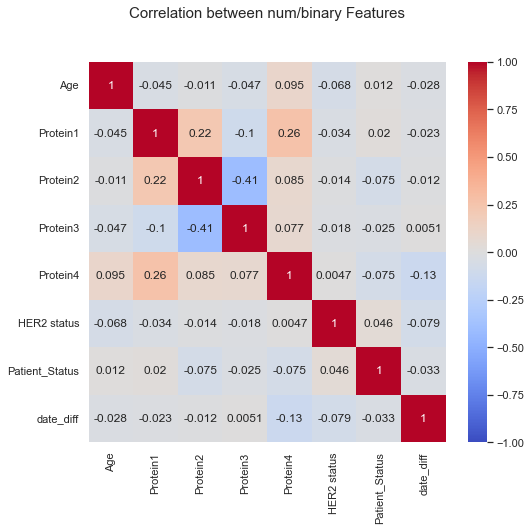

In [161]:
# plot correlation to get an idea about the imputation values
# get heatmap for correlation between numerical/binary features
plt.figure(figsize=(8, 7))
sns.set_context("notebook")
sns.heatmap(tmp_df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title("Correlation between num/binary Features", fontsize=15, y=1.1)

# Missing Values

Text(0.5, 0, 'Features')

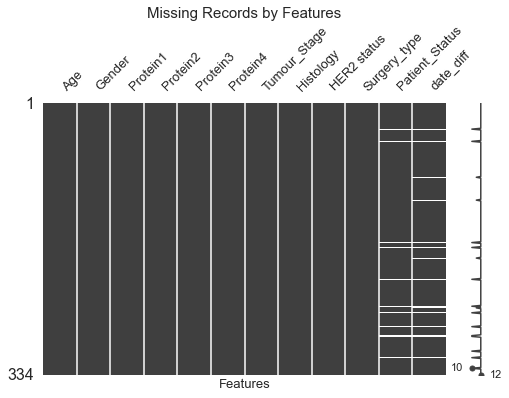

In [166]:
# visualize the missing values
# sns.set_context("notebook")
%matplotlib inline
msno.matrix(df.sample(frac=1), figsize=(8, 5), fontsize=13)
plt.title("Missing Records by Features", fontsize=15)
plt.xlabel("Features", fontsize=13)

In [ ]:
# drop records are completely empty
df.dropna(how="all", inplace=True)

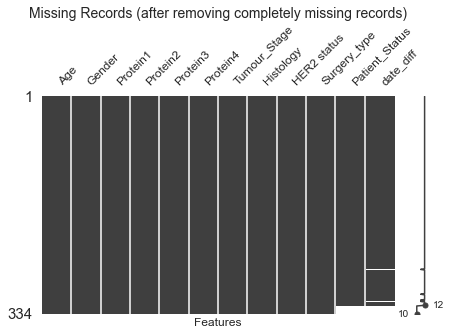

In [ ]:
# visualize the missing records again
msno.matrix(df.sort_values("Patient_Status"), figsize=(7, 4), fontsize=12);
plt.title("Missing Records (after removing completely missing records)", fontsize=14);
plt.xlabel("Features", fontsize=12);

In [168]:
# get the possible imputation values
df.groupby("Patient_Status").date_diff.agg(["mean", "median"])

,mean,median
Patient_Status,,
Alive,441.443137,372.0
Dead,473.822581,365.0


Text(0.5, 1.0, 'Distributions of date-diff by Patient-Status')

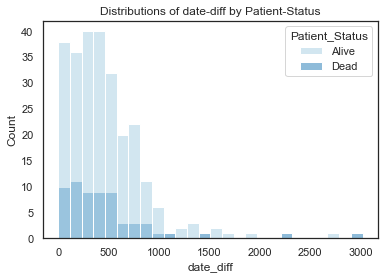

In [175]:
# plot the distribution of `date_diff`
sns.set_style("white")
plt.figure(figsize=(6, 4))
sns.histplot(data=df.dropna(), x="date_diff" , hue="Patient_Status", palette="Paired")
plt.title("Distributions of date-diff by Patient-Status")

Distribution seems to be highly skewed which indicates that we should consider using median for imputations.

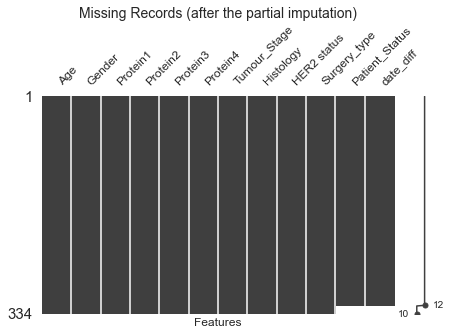

In [178]:
df.loc[(df.date_diff.isna())&df.Patient_Status.notna(), "date_diff"] = 365

# visualize the missing records again after partial imputations
msno.matrix(df.sort_values("Patient_Status"), figsize=(7, 4), fontsize=12);
plt.title("Missing Records (after the partial imputation)", fontsize=14);
plt.xlabel("Features", fontsize=12);

In [179]:
# number of missing records in the Patient_Status column
df.Patient_Status.isna().sum()

13

In [180]:
# print the partial missing records
df = df.sort_values("Patient_Status").reset_index(drop=True)
df.tail(13)

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status,date_diff
321,50,FEMALE,0.672490,1.27900,-0.321070,-0.11239,III,Infiltrating Ductal Carcinoma,Negative,Simple Mastectomy,NaN,<NA>
322,55,FEMALE,0.330640,0.84757,-0.494660,0.11656,I,Infiltrating Lobular Carcinoma,Negative,Modified Radical Mastectomy,NaN,<NA>
323,60,FEMALE,0.532420,1.54110,-1.009500,-0.12588,I,Infiltrating Ductal Carcinoma,Negative,Other,NaN,<NA>
324,44,FEMALE,-0.278840,2.16880,-0.462330,0.27220,II,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,NaN,<NA>
325,40,FEMALE,-1.455300,-0.74177,1.133600,-0.83970,III,Infiltrating Lobular Carcinoma,Negative,Other,NaN,<NA>
326,46,FEMALE,-0.010999,0.86749,0.281570,-0.54588,II,Infiltrating Lobular Carcinoma,Negative,Other,NaN,<NA>
327,71,FEMALE,0.394090,1.70540,0.035642,1.44100,II,Infiltrating Lobular Carcinoma,Negative,Modified Radical Mastectomy,NaN,<NA>
328,62,FEMALE,0.649340,1.81680,0.279260,0.13228,II,Infiltrating Lobular Carcinoma,Negative,Other,NaN,<NA>
329,50,FEMALE,-0.322890,0.98848,-0.293130,-0.26170,II,Infiltrating Ductal Carcinoma,Negative,Other,NaN,<NA>
330,88,FEMALE,-2.340900,0.37246,0.208450,-1.64110,I,Infiltrating Ductal Carcinoma,Negative,Simple Mastectomy,NaN,<NA>


# Imputing Missing Values

In [181]:
# get a copy of the original data frame to impute the missing values
df_ = df.copy()
date_diff_col = df_.date_diff
df_.drop("date_diff", axis=1, inplace=True)

In [182]:
# extract the records with missing values and drop them
missing_rec = df_.tail(13)
df_.dropna(inplace=True)

In [183]:
# check if there are any missing values
print(f"There are {df_.isna().sum().sum()} missing values in the data frame.")

There are 0 missing values in the data frame.


In [186]:
# seperate the features and the missing values' column `Patient_Status` for imputations
target = df_.columns.isin(["Patient_Status"])
feats = ~target
X = df_[df_.columns[feats]]
y = df_[df_.columns[target]].apply(lambda x: 1 if x["Patient_Status"]=="Alive" else 0, axis=1)
X.shape, y.shape

((321, 10), (321,))

In [187]:
# split the data into train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [188]:
# Pool the evaluation dataset
eval_set = Pool(X_test, y_test, cat_features=df.select_dtypes("object").columns.tolist()[:-1],)

In [189]:
# initialize the CatBoostClassifier as `imputer` and fit the training data
imputer = CatBoostClassifier(cat_features=df.select_dtypes("object").columns.tolist()[:-1])
imputer.fit(X_train, y_train, eval_set=eval_set, verbose=False)

In [190]:
# check the validation accuracy
print(f"The validation accuray is: {imputer.score(X_test, y_test)}")

The validation accuray is: 0.8


In [192]:
# perform predictions on the missing values' records
pred_missing_rec = imputer.predict(missing_rec.loc[:, missing_rec.columns[feats]], prediction_type="Probability")
pred_missing_rec

array([[0.09342713, 0.90657287],
       [0.19502112, 0.80497888],
       [0.17163877, 0.82836123],
       [0.3182909 , 0.6817091 ],
       [0.11264781, 0.88735219],
       [0.10841246, 0.89158754],
       [0.32217146, 0.67782854],
       [0.12072347, 0.87927653],
       [0.15794531, 0.84205469],
       [0.07948942, 0.92051058],
       [0.0351213 , 0.9648787 ],
       [0.20004496, 0.79995504],
       [0.3855648 , 0.6144352 ]])

In [193]:
# get the probabilities above in a correct format
pred_missing_rec = np.argmax(pred_missing_rec, axis=1)
pred_missing_rec = ["Alive" if status==1 else "Dead" for status in pred_missing_rec]
pred_missing_rec

['Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive',
 'Alive']

In [194]:
# contatenate the `df_` with no missing value and the records that are recently imputed
missing_rec.loc[:, "Patient_Status"] = pred_missing_rec
final_df = pd.concat([df_, missing_rec], axis=0)
final_df = pd.concat([final_df, date_diff_col], axis=1)
final_df.tail()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status,date_diff
329,50,FEMALE,-0.32289,0.98848,-0.293130,-0.26170,II,Infiltrating Ductal Carcinoma,Negative,Other,Alive,<NA>
330,88,FEMALE,-2.34090,0.37246,0.208450,-1.64110,I,Infiltrating Ductal Carcinoma,Negative,Simple Mastectomy,Alive,<NA>
331,80,FEMALE,0.67077,-0.71039,0.186480,0.14664,II,Infiltrating Lobular Carcinoma,Negative,Other,Alive,<NA>
332,56,FEMALE,-0.67542,0.26937,-0.086603,1.07140,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,<NA>
333,67,FEMALE,0.31742,-0.55585,0.356570,0.79733,II,Infiltrating Ductal Carcinoma,Negative,Other,Alive,<NA>


In [195]:
# check the info of `final_df`
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 333
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             334 non-null    int64  
 1   Gender          334 non-null    object 
 2   Protein1        334 non-null    float64
 3   Protein2        334 non-null    float64
 4   Protein3        334 non-null    float64
 5   Protein4        334 non-null    float64
 6   Tumour_Stage    334 non-null    object 
 7   Histology       334 non-null    object 
 8   HER2 status     334 non-null    object 
 9   Surgery_type    334 non-null    object 
 10  Patient_Status  334 non-null    object 
 11  date_diff       321 non-null    Int32  
dtypes: Int32(1), float64(4), int64(1), object(6)
memory usage: 32.9+ KB


Text(0.5, 0, 'Features')

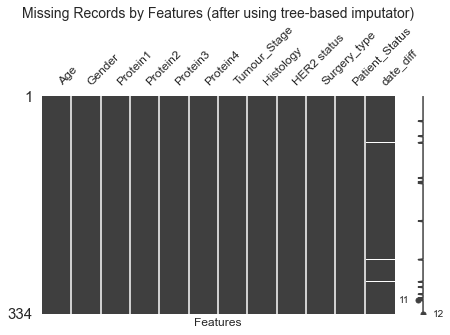

In [196]:
# visualize the missing values
msno.matrix(final_df.sample(frac=1), figsize=(7, 4), fontsize=12);
plt.title("Missing Records by Features (after using tree-based imputator)", fontsize=14);
plt.xlabel("Features", fontsize=12)

In [197]:
# print the missing records
final_df[final_df.date_diff.isna()]

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status,date_diff
321,50,FEMALE,0.672490,1.27900,-0.321070,-0.11239,III,Infiltrating Ductal Carcinoma,Negative,Simple Mastectomy,Alive,<NA>
322,55,FEMALE,0.330640,0.84757,-0.494660,0.11656,I,Infiltrating Lobular Carcinoma,Negative,Modified Radical Mastectomy,Alive,<NA>
323,60,FEMALE,0.532420,1.54110,-1.009500,-0.12588,I,Infiltrating Ductal Carcinoma,Negative,Other,Alive,<NA>
324,44,FEMALE,-0.278840,2.16880,-0.462330,0.27220,II,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,<NA>
325,40,FEMALE,-1.455300,-0.74177,1.133600,-0.83970,III,Infiltrating Lobular Carcinoma,Negative,Other,Alive,<NA>
326,46,FEMALE,-0.010999,0.86749,0.281570,-0.54588,II,Infiltrating Lobular Carcinoma,Negative,Other,Alive,<NA>
327,71,FEMALE,0.394090,1.70540,0.035642,1.44100,II,Infiltrating Lobular Carcinoma,Negative,Modified Radical Mastectomy,Alive,<NA>
328,62,FEMALE,0.649340,1.81680,0.279260,0.13228,II,Infiltrating Lobular Carcinoma,Negative,Other,Alive,<NA>
329,50,FEMALE,-0.322890,0.98848,-0.293130,-0.26170,II,Infiltrating Ductal Carcinoma,Negative,Other,Alive,<NA>
330,88,FEMALE,-2.340900,0.37246,0.208450,-1.64110,I,Infiltrating Ductal Carcinoma,Negative,Simple Mastectomy,Alive,<NA>


It would seem that the Patient_Status is Alive where the date_diff has missing values.

In [198]:
# get the median values of date_diff by Patient_Status and impute them
impute_val = final_df.groupby("Patient_Status").date_diff.agg("median").Alive

final_df.loc[final_df.date_diff.isna(), "date_diff"] = impute_val

print(f"There are {final_df.isna().sum().sum()} missing values in the dataset.")

There are 0 missing values in the dataset.


In [199]:
# `Patient_Status` proportions after imputations
final_df.Patient_Status.value_counts(normalize=True).to_frame()

,Patient_Status
Alive,0.802395
Dead,0.197605


In [200]:
# visualize the `Patient_Status` proportions before and after imputations
props_df = pd.concat([df.Patient_Status.value_counts(normalize=True).to_frame(), final_df.Patient_Status.value_counts(normalize=True).to_frame()], axis=1)
props_df.columns = ["No Imputations", "With Imputations"]

fig = px.bar(
    data_frame=props_df.T,
    width=400,
    height=400,
)

fig.update_layout(xaxis_title=dict(text='<b>'"Patient Status"'</b>',
                                   font=dict(
                                   size=13)),
                  yaxis_title=dict(text='<b>'"Proportions"'</b>',
                                   font=dict(
                                   size=13)),
                  legend_title_text="Class",
                  title=dict(text='<b>Patient-Status before and after Imputations</b>',
                             x=0.5,
                             y=0.95,
                             font=dict(
                                size=14,
                                color='#000000'
                             )),
                  hovermode="x"
)

fig.update_traces(hovertemplate=None)

fig.show()

# Testing

- Tumour Stages dependency on HER2-Status

In [201]:
# `Tumour Stages` by `HER status` Proportions
final_df.groupby("Tumour_Stage")["HER2 status"].value_counts(normalize=True).unstack()

HER2 status,Negative,Positive
Tumour_Stage,,
I,0.953125,0.046875
II,0.931217,0.068783
III,0.839506,0.160494


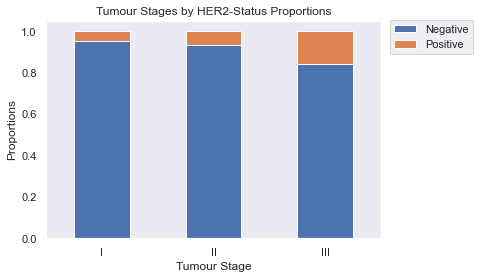

In [203]:
# visualize `Tumour Stages` by `HER status` Proportions
sns.set_style("dark")
final_df.groupby("Tumour_Stage")["HER2 status"].value_counts(normalize=True).unstack()\
                        .plot.bar(stacked=True,
                                  xlabel="Tumour Stage",
                                  ylabel="Proportions",
                                  title="Tumour Stages by HER2-Status Proportions",
                                  figsize=(6, 4))
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.01, 1.03))

We can observe that Tumour Stages advances as more the HER2 status turns positive.

In [204]:
# perform proportions-ztest
alpha = 0.05
n_ps_1 = [13, 13]
n_row_1 = [13+176, 13+68]

stat, p_val = proportions_ztest(count=n_ps_1,
                                nobs=n_row_1,
                                alternative="smaller")
if p_val <= alpha:
    print(f"Since, p-value={p_val:.2f}\n\nWe reject the Null Hypothesis Ho.")
else:
    print(f"We fail to reject the Null Hypothesis Ho as the p-value {p_val:.2f} is larger than {alpha}.")

Since, p-value=0.01

We reject the Null Hypothesis Ho.


- Relationship between Histology and HER2-Status

(array([0, 1]), [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

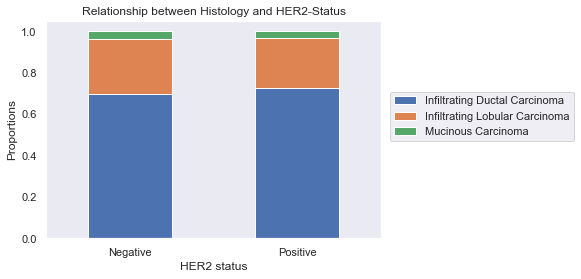

In [205]:
# relationship between Histology and HER2-Status
final_df.groupby("HER2 status").Histology.value_counts(normalize=True).unstack().plot.bar(stacked=True, figsize=(6, 4), ylabel="Proportions")
plt.legend(bbox_to_anchor=(1.01, 0.7))
plt.title("Relationship between Histology and HER2-Status")
plt.xticks(rotation=0)

Null Hypothesis Ho: There is no relationhip between HER2 Status and Histology.

Alternative Hypothesis H1: There is a relationhip between HER2 Status and Histology.

Statistical Significance α : 0.05

In [206]:
# perform the chi-squared test of indpendence to conclude the results
alpha = 0.05

_, _, stats = pgn.chi2_independence(data=final_df,
                                    x="Histology",
                                    y="HER2 status")

print(stats[stats["test"].isin(["pearson"])][["pval", "power"]])

p_val = stats[stats["test"].isin(["pearson"])].pval.values

if p_val <= alpha:
    print(f"\nWe reject the Null Hypothesis Ho and can say that there is no relationhip between *HER2 Status* and *Histology*.")
else:
    print(f"\nWe fail to reject the Null Hypothesis Ho as the p-value {p_val[0]:.2f} is larger than {alpha}.")

       pval     power
0  0.947003  0.058265

We fail to reject the Null Hypothesis Ho as the p-value 0.95 is larger than 0.05.


- Effect of Proteins on the Patient's survival by Tumour Stage

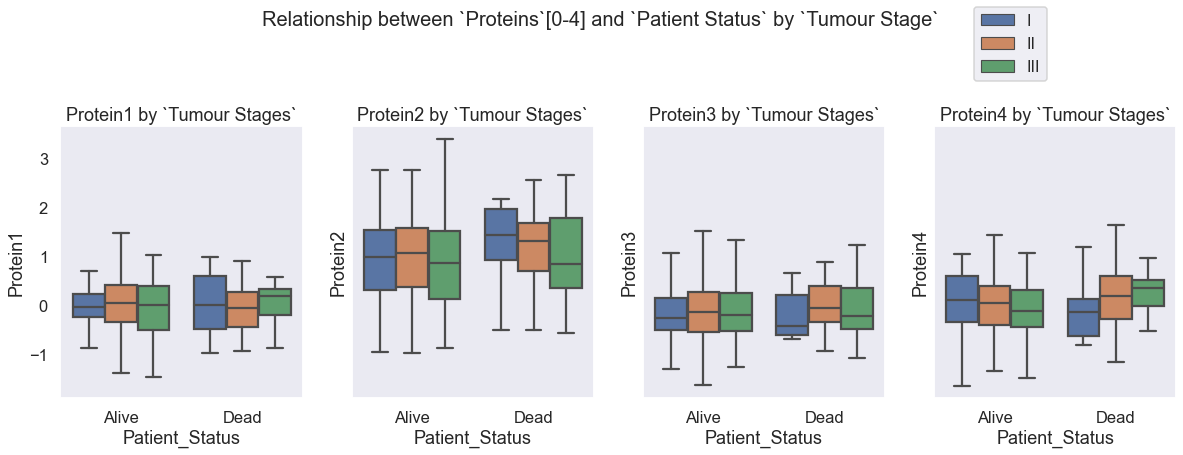

In [207]:
# relationship between `Proteins` and `Tumour Stage` by `Patient Status`
sns.set_context("talk")

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
ax = ax.flatten()
plot=0

for row in ["Protein1", "Protein2", "Protein3", "Protein4"]:
    sns.boxplot(data=final_df.sort_values("Tumour_Stage"), x='Patient_Status', y=f"{row}", hue="Tumour_Stage", ax=ax[plot], sym="")
    ax[plot].set_title(f"{row} by `Tumour Stages`")
    plot+=1

for i in range(plot-1):
    ax[i].get_legend().remove()

ax[plot-1].legend(bbox_to_anchor=(0.5, 1.47))
fig.suptitle("Relationship between `Proteins`[0-4] and `Patient Status` by `Tumour Stage`", y=1.2, fontsize=20);
plt.show()

Null Hypothesis Ho: Patients with Tumour Stage-III that are alive had same Protein4 distribution as that of the Alive Patients with Tumour Stage-II and Tumour Stage-I.

Alternative Hypothesis H1: Patients with Tumour Stage-III that are Alive had different Protein4 distribtutions than the Alive Patients with Tumour Stage-II and Tumour Stage-I.

α : 0.05

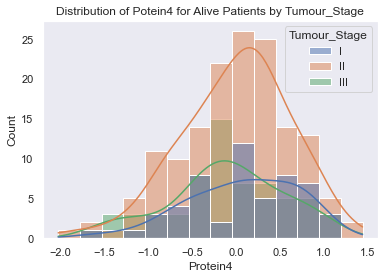

The three distributions are normal: False, False, False
The number of observations for the three respective distributions are: 54, 151, 63


In [217]:
# get the distributions
sns.histplot(final_df[final_df.Patient_Status.isin(["Alive"])].sort_values("Tumour_Stage"), x="Protein4", hue="Tumour_Stage", kde=True)
plt.title("Distribution of Potein4 for Alive Patients by Tumour_Stage")
plt.show()

first_dist = final_df[(final_df.Patient_Status=="Alive") & (final_df.Tumour_Stage=="I")].Protein4
second_dist = final_df[(final_df.Patient_Status=="Alive") & (final_df.Tumour_Stage=="II")].Protein4
third_dist = final_df[(final_df.Patient_Status=="Alive") & (final_df.Tumour_Stage=="III")].Protein4

norm_1 = st.shapiro(first_dist.values)[1] < 0.05
norm_2 = st.shapiro(second_dist.values)[1] < 0.05
norm_3 = st.shapiro(third_dist.values)[1] < 0.05

print(f"The three distributions are normal: {norm_1}, {norm_2}, {norm_3}")
print(f"The number of observations for the three respective distributions are: {first_dist.shape[0]}, {second_dist.shape[0]}, {third_dist.shape[0]}")

In [210]:
# power analysis for `sample size`
analysis = pwr.TTestIndPower()

result = analysis.solve_power(
                        effect_size=0.2, # need a smaller effect size considering the cdf plotted above
                        power=0.8, # (0, 1) greater the power lower the risk of getting Type-II error
                        alpha=0.05, # statistical significance
                        ratio=54/151, # sample size ratio of: Proteins4 of Alive Patients (Tumour-Stage I) / Proteins1 of Alive Patients (Tumour-Stage II)
                        nobs1=None # number of observations that we are going to find out for this use-case
                        )

print(f"We need about {result:.0f} of observations to perform hypothesis testing which is quite large than the majority class `Alive`.")

We need about 746 of observations to perform hypothesis testing which is quite large than the majority class `Alive`.


- Surgeries performed on Patients by Tumour Stages

In [211]:
# print the `final_df`
final_df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,HER2 status,Surgery_type,Patient_Status,date_diff
0,36,FEMALE,0.080353,0.42638,0.54715,0.27368,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,155
1,77,FEMALE,0.477710,0.81881,-0.40630,-0.65479,I,Infiltrating Lobular Carcinoma,Negative,Lumpectomy,Alive,791
2,54,FEMALE,0.514320,1.69360,-0.14401,1.02490,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,374
3,49,FEMALE,-0.144410,2.32400,-0.70744,0.71895,III,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,Alive,222
4,44,FEMALE,0.964050,0.82304,-0.30715,-0.14975,III,Infiltrating Ductal Carcinoma,Negative,Lumpectomy,Alive,641


In [212]:
# plot `Tumor_Stage` proportions by `Surgery_Type`
fig = px.bar(
    data_frame=final_df.groupby("Tumour_Stage").Surgery_type.value_counts(normalize=True, sort=True).unstack(),
    height=400,
    width=600
)

fig.update_layout(xaxis_title=dict(text='<b>Tumour Stage</b>',
                                   font=dict(
                                   size=13)),
                  yaxis_title=dict(text='<b>'"Proportions"'</b>',
                                   font=dict(
                                   size=13)),
                  legend_title_text='<b>Surgery Type</b>',
                  title=dict(text='<b>Surgery Performed on Patients by Tumour Stages</b>',
                             x=0.5,
                             y=0.95,
                             font=dict(
                                size=14,
                                color='#000000'
                             )),
                  hovermode="x"
)

fig.update_traces(hovertemplate=None)

fig.show()

clearly seems to be a difference between the Surgery procedures being performed for different Tumour Stage Patients.

Null Hypothesis Ho: Surgery Procedures are independent of Patients' Tumour Stages.

Alternative Hypothesis H1: Surgery Procedures are dependent on the Patients' Tumour Stages.

α : 0.05

In [214]:
# perform the chi-squared test of indpendence to conclude the results
alpha = 0.05

_, _, stats = pgn.chi2_independence(data=final_df,
                                    x="Tumour_Stage",
                                    y="Surgery_type")

print(stats[stats["test"].isin(["pearson"])][["pval", "power"]])

p_val = stats[stats["test"].isin(["pearson"])].pval.values

if p_val <= alpha:
    print(f"\nWe reject the Null Hypothesis Ho and come to a conclusion that Surgery Procedures dependend on the Patients' Tumour Stages.")
else:
    print(f"\nWe fail to reject the Null Hypothesis Ho as the p-value {p_val:.2f} is larger than {alpha}.")

       pval   power
0  0.000022  0.8604

We reject the Null Hypothesis Ho and come to a conclusion that Surgery Procedures dependend on the Patients' Tumour Stages.


- Mean Patients' Age by Tumour Stages (to define skewness)

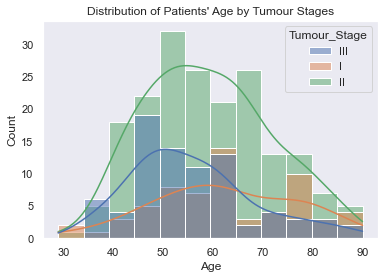

Tumour Stage I: ShapiroResult(statistic=0.9820309281349182, pvalue=0.4755757749080658)
Tumour Stage II: ShapiroResult(statistic=0.9830440878868103, pvalue=0.021880697458982468)
Tumour Stage III: ShapiroResult(statistic=0.9523248076438904, pvalue=0.004373527597635984)


In [218]:
# plot a distribution of Age by Tumour Stages
sns.histplot(final_df, x="Age", hue="Tumour_Stage", kde=True)
plt.title("Distribution of Patients' Age by Tumour Stages")
plt.show()

# check if the data drawn from each Tumour Stage for Age is normally distributed
for i in final_df.groupby("Tumour_Stage").Age:
    print(f"Tumour Stage {i[0]}: {st.shapiro(i[1])}")

Null Hypothesis Ho: Mean patient age is different for different tumour stages

Alternative Hypothesis H1: Mean patient age is different for different tumour stages

Statistical Significance α : 0.05


In [219]:
# perform kruskal test to check if the mean patient age is different for different tumour stages 
alpha = 0.05
stats = pgn.kruskal(data=final_df,
                    dv="Age",
                    between="Tumour_Stage")

p_val = stats["p-unc"].values[0]

if p_val <= alpha:
    print(f"We reject the Null Hypothesis Ho as the p-value {p_val:.2f} is smaller than {alpha}, and come to a conclusion that at-least one mean patient age is different for different tumour stages .")
else:
    print(f"We fail to reject the Null Hypothesis Ho as the p-value {p_val:.2f} is larger than {alpha}.")

We reject the Null Hypothesis Ho as the p-value 0.01 is smaller than 0.05, and come to a conclusion that at-least one mean patient age is different for different tumour stages .


- Patients' Survival Curve by Tumour-Stages (Non-Parametric)

In [220]:
# get the data in the right shape
survival_df = df.dropna(how="any")[["Tumour_Stage", "date_diff", "Patient_Status"]].copy()
survival_df["has_passed_away"] = survival_df.apply(lambda row: 0 if row.Patient_Status=="Alive" else 1, axis=1).astype("int32")

# drop uneccessary features
survival_df.drop("Patient_Status", axis=1, inplace=True)

# print the survival_df
survival_df.head()

,Tumour_Stage,date_diff,has_passed_away
0,III,155,0
1,I,791,0
2,III,374,0
3,III,222,0
4,III,641,0


In [221]:
# check whether the survival curve will be valid
survival_df.groupby("Tumour_Stage").has_passed_away.value_counts(normalize=True)

Tumour_Stage  has_passed_away
I             0                  0.836066
              1                  0.163934
II            0                  0.791209
              1                  0.208791
III           0                  0.769231
              1                  0.230769
Name: has_passed_away, dtype: float64

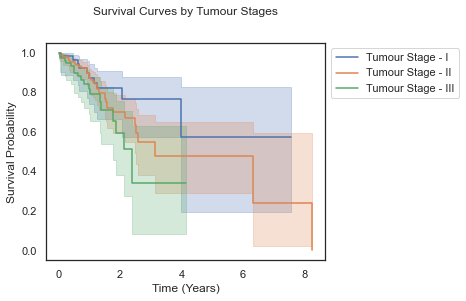

In [222]:
# plot the survival curve
kmf = KaplanMeierFitter()

stage_1_df = survival_df[survival_df.Tumour_Stage=="I"]
stage_2_df = survival_df[survival_df.Tumour_Stage=="II"]
stage_3_df = survival_df[survival_df.Tumour_Stage=="III"]

sns.set_style("white")
plt.figure(figsize=(5, 4))

kmf.fit(durations=stage_1_df["date_diff"].values/365.5, event_observed=stage_1_df["has_passed_away"].values, label="Tumour Stage - I")
kmf.plot()

kmf.fit(durations=stage_2_df["date_diff"].values/365.5, event_observed=stage_2_df["has_passed_away"].values, label="Tumour Stage - II")
kmf.plot()

kmf.fit(durations=stage_3_df["date_diff"].values/365.5, event_observed=stage_3_df["has_passed_away"].values, label="Tumour Stage - III")
kmf.plot()

plt.title("Survival Curves by Tumour Stages", y=1.1)
plt.ylabel("Survival Probability")
plt.xlabel("Time (Years)")ؤ
plt.legend(bbox_to_anchor=(1.5, 1))

Null Hypothesis Ho: There is no difference between the survival curves of patients belonging to Tumour Stage - I and Tumour Stage - III categories.

Alternative Hypothesis H1: There is a difference between the survival curves of patients belonging to Tumour Stage - I and Tumour Stage - III categories.

α : 0.05

In [223]:
# `logrank test` to compares survival probabilities between groups at each time
lrt = logrank_test(durations_A=stage_1_df["date_diff"].values/365.5,
                   durations_B=stage_2_df["date_diff"].values/365.5,
                   event_observed_A=stage_1_df["has_passed_away"].values,
                   event_observed_B=stage_2_df["has_passed_away"].values)

lrt

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.31 0.25      1.99